In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# options = ["strong_big", "strong_medium", "strong_small", "strong_custom", "weak_medium", "weak_small", "weak_custom"]
options = ["strong_custom", "weak_custom"]

datas = []
for option in options:
    datas.append(pd.read_csv(f"./results/{option}.csv", names=["size", "proc", "time"]))

sizes = [data["size"].unique()[0] for data in datas]
for data in datas:
    data.drop(columns=["size"], inplace=True)

In [84]:
colors = ["red", "green", "blue", "orange", "purple", "pink"]

def plot_avg_std(datas, avg_datas, y, x_label, y_label, title, draw_x_eq_y=False):
    fig, ax = plt.subplots()

    if draw_x_eq_y:
        ax.plot(
            np.arange(1, 13, 1),
            np.arange(1, 13, 1),
            color="black",
            linewidth=1,
            alpha=1
        )

        ax.set_yticks(np.arange(0, 13, 1))

    for i, data in enumerate(datas):
        # err by min max
        # asym_err = [
        #     avg_data[i][y] - datas[i].groupby("proc").min().reset_index()[y],
        #     datas[i].groupby("proc").max().reset_index()[y] - avg_data[i][y]
        # ]

        ax.errorbar(
            avg_datas[i]["proc"],
            avg_datas[i][y],
            yerr=datas[i].groupby("proc").std().reset_index()[y],
            # yerr=asym_err,
            color=colors[i],
            fmt='o',
            barsabove=True,
            markersize=3,
            capsize=5, elinewidth=0.5, markeredgewidth=1,
        )

        # ax.plot(
        #     avg_datas[i]["proc"],
        #     avg_datas[i][y],
        #     color=colors[i],
        #     linestyle=(i, (3, 3)),
        #     linewidth=1,
        #     alpha=0.5
        # )

    ax.set(xlabel=x_label, ylabel=y_label, title=title)
    ax.set_xticks(np.arange(1, 13, 1))
    
    ax.grid()

    for i, size in enumerate(sizes):
        ax.plot([], [], color=colors[i], label=f"Problem: {options[i]}")
    ax.legend()

    fig.set_dpi(600)

    plt.savefig(f"./results/{title.replace(' ', '_')}.png")
    plt.show()

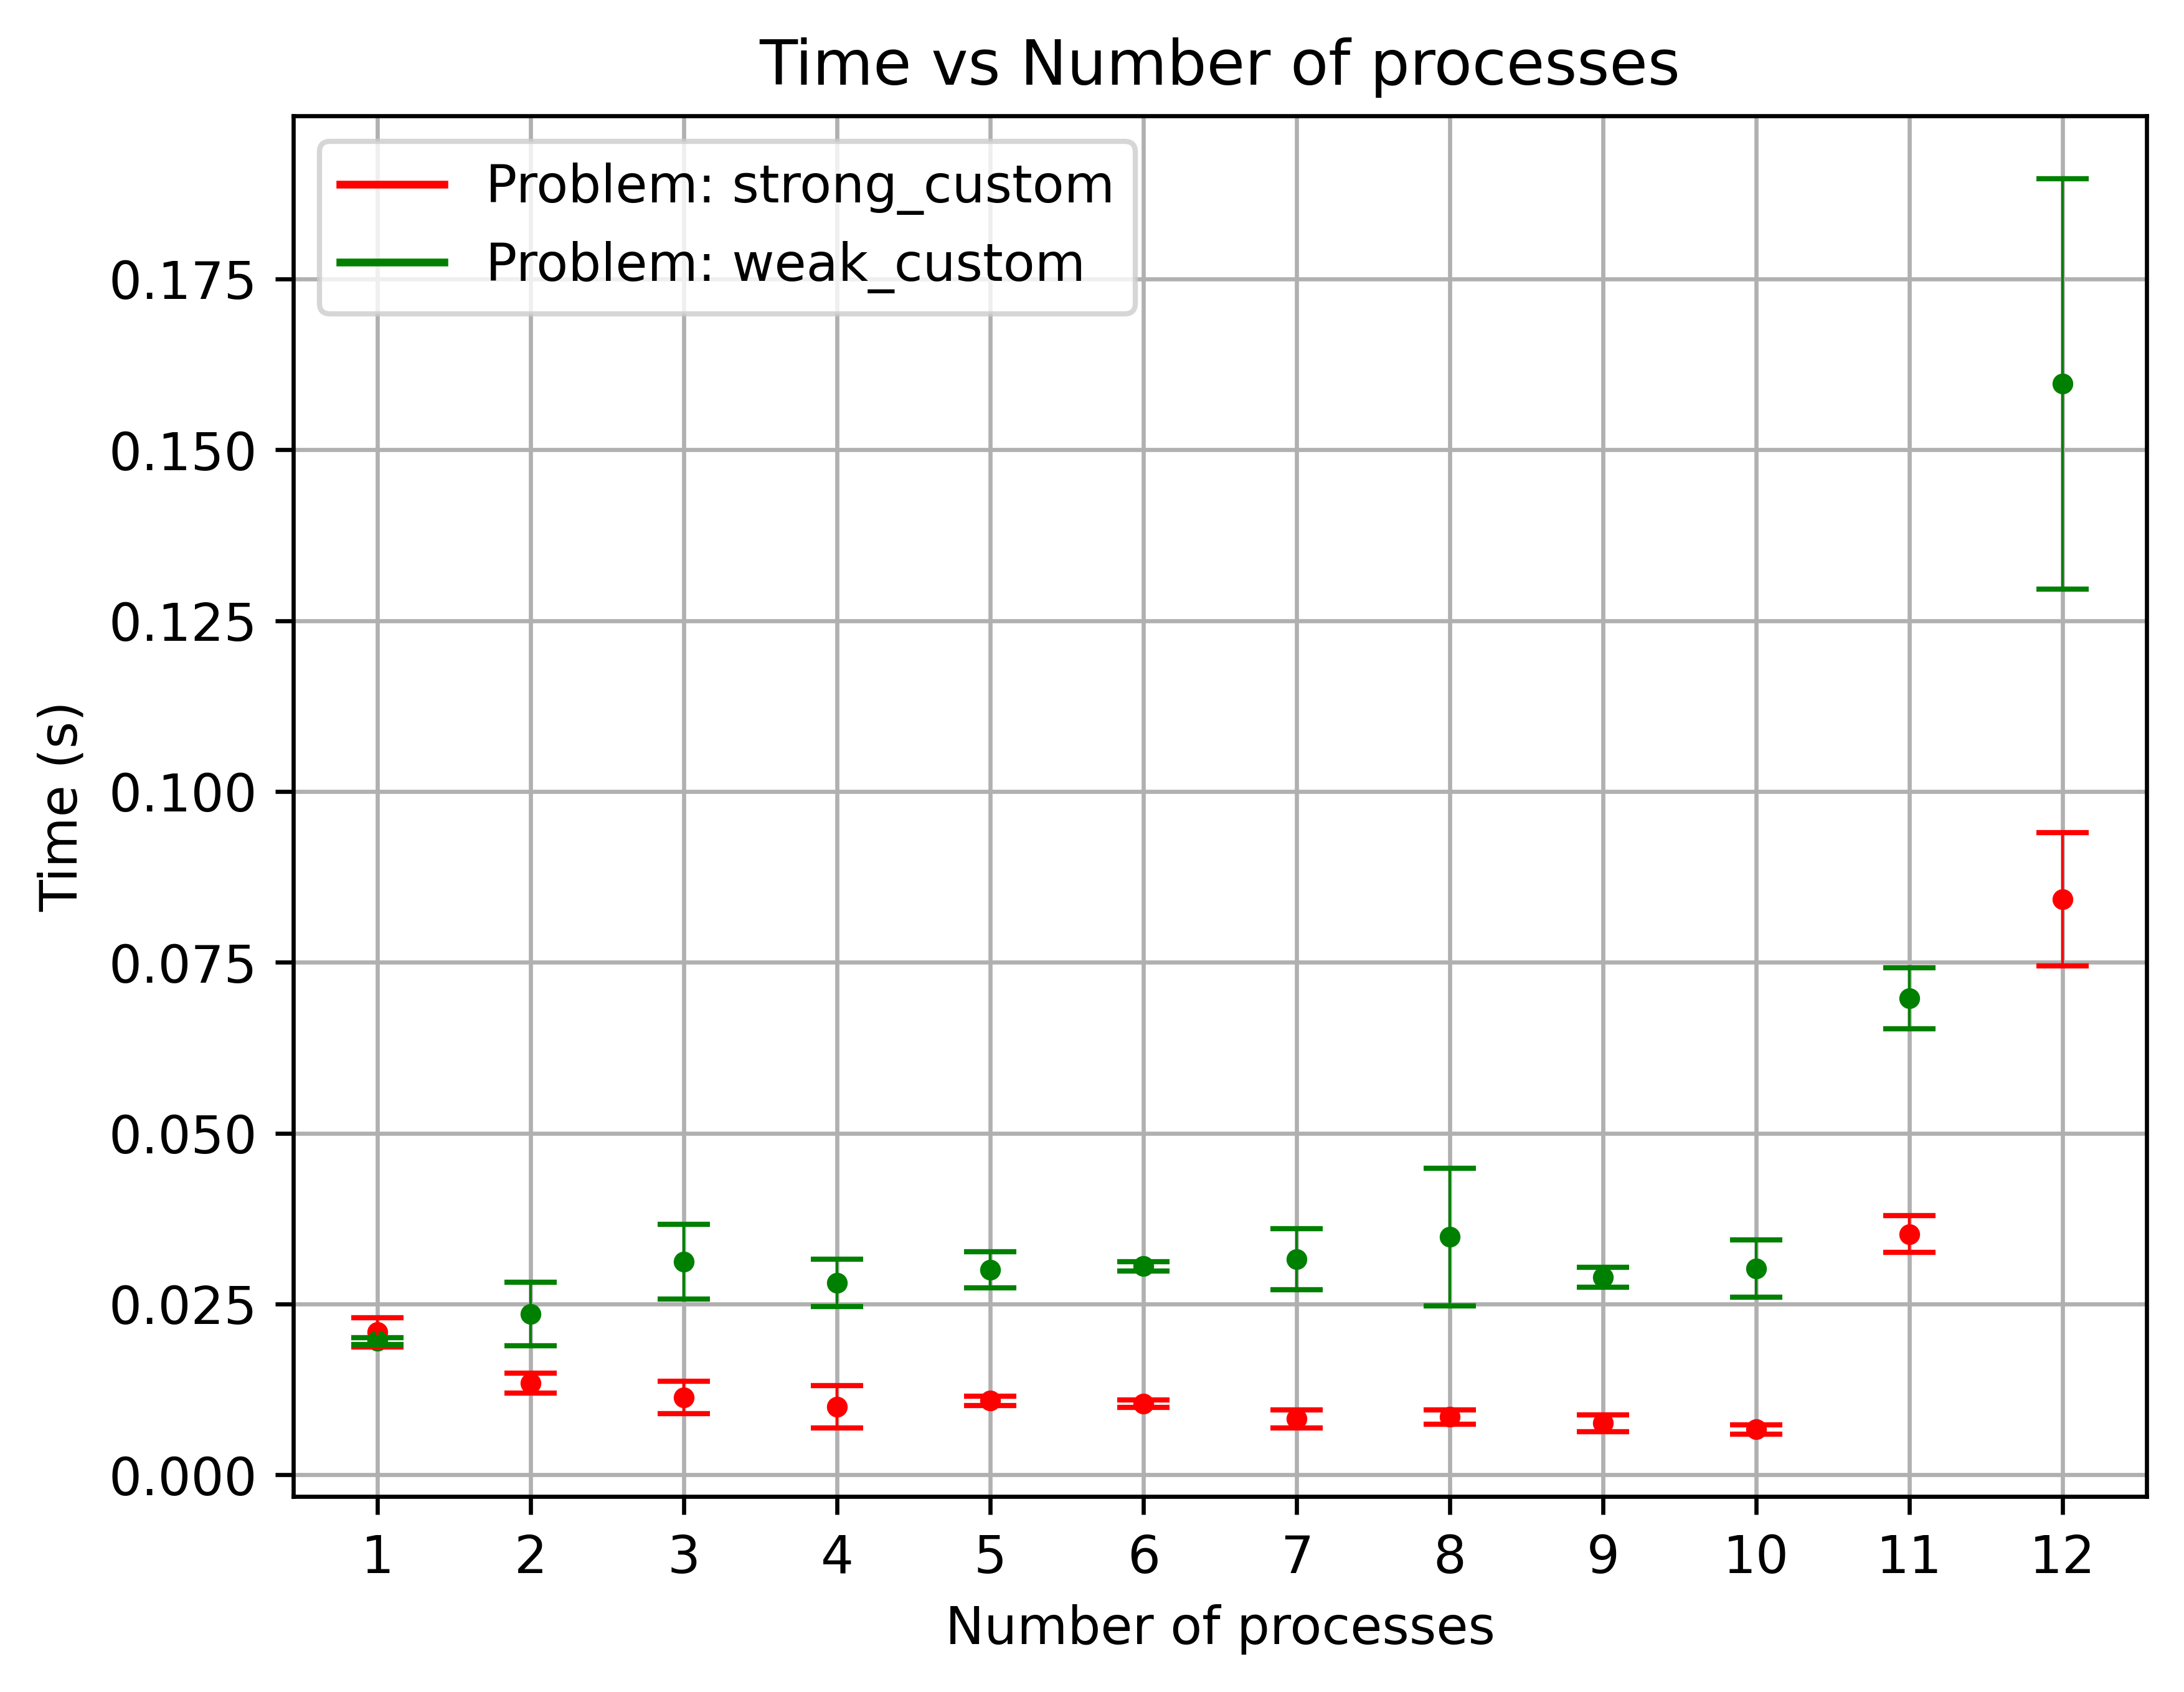

In [85]:
avg_datas = []
for data in datas:
    avg_datas.append(data.groupby("proc").mean().reset_index())

plot_avg_std(datas, avg_datas, "time", "Number of processes", "Time (s)", "Time vs Number of processes")

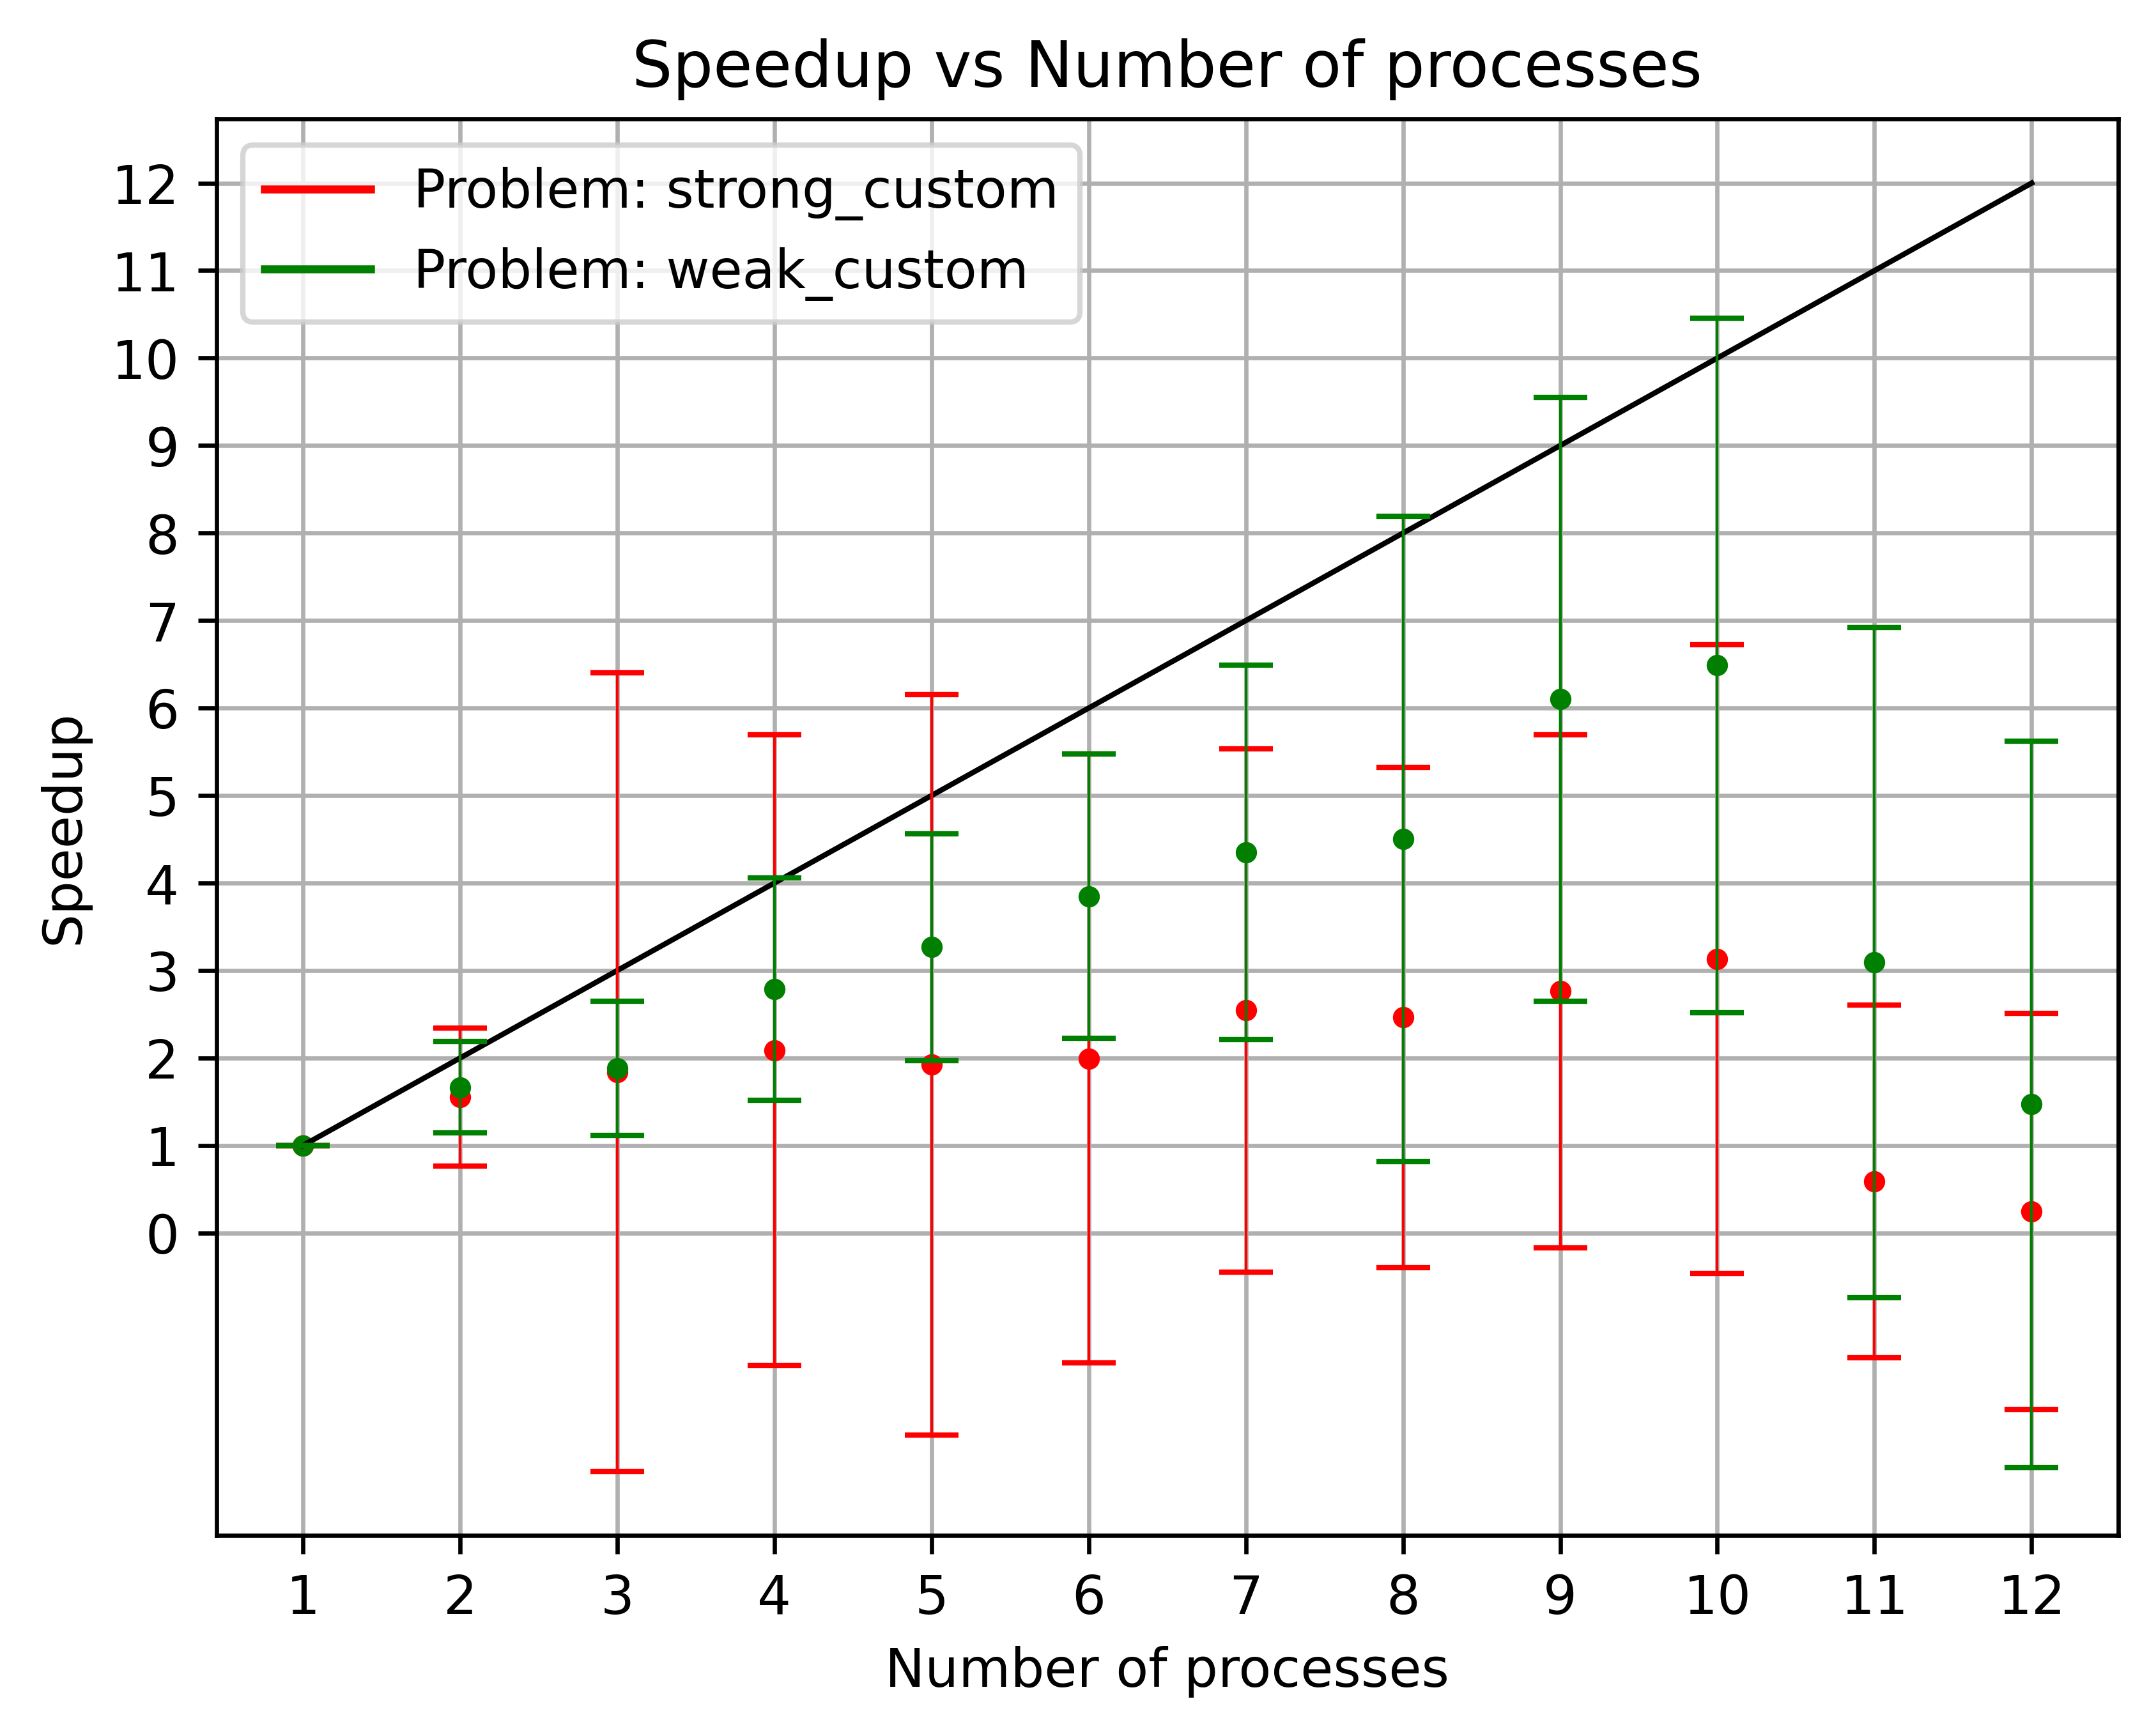

In [86]:
# calculate speedups

def calc_speedups(datas):
    speedups_data = []

    for data_i, data in enumerate(datas):
        speedups_data.append(pd.DataFrame(columns=["proc", "speedup"]))

        # calculate speedup for every 12 lines until the end of data
        for i in range(0, len(data)):
            # for datas from weak scaling multiply by number of processes
            speedups_data[-1].loc[len(speedups_data[-1])] = [(i % 12) + 1, (((i % 12) + 1) if data_i >= max(len(options) // 2, 1)  else 1) * data["time"][(i // 12) * 12] / data["time"][i]]

    return speedups_data


speedups_data = calc_speedups(datas)
speedups_avg_data = calc_speedups(avg_datas)

plot_avg_std(speedups_data, speedups_avg_data, "speedup", "Number of processes", "Speedup", "Speedup vs Number of processes", draw_x_eq_y=True)
    

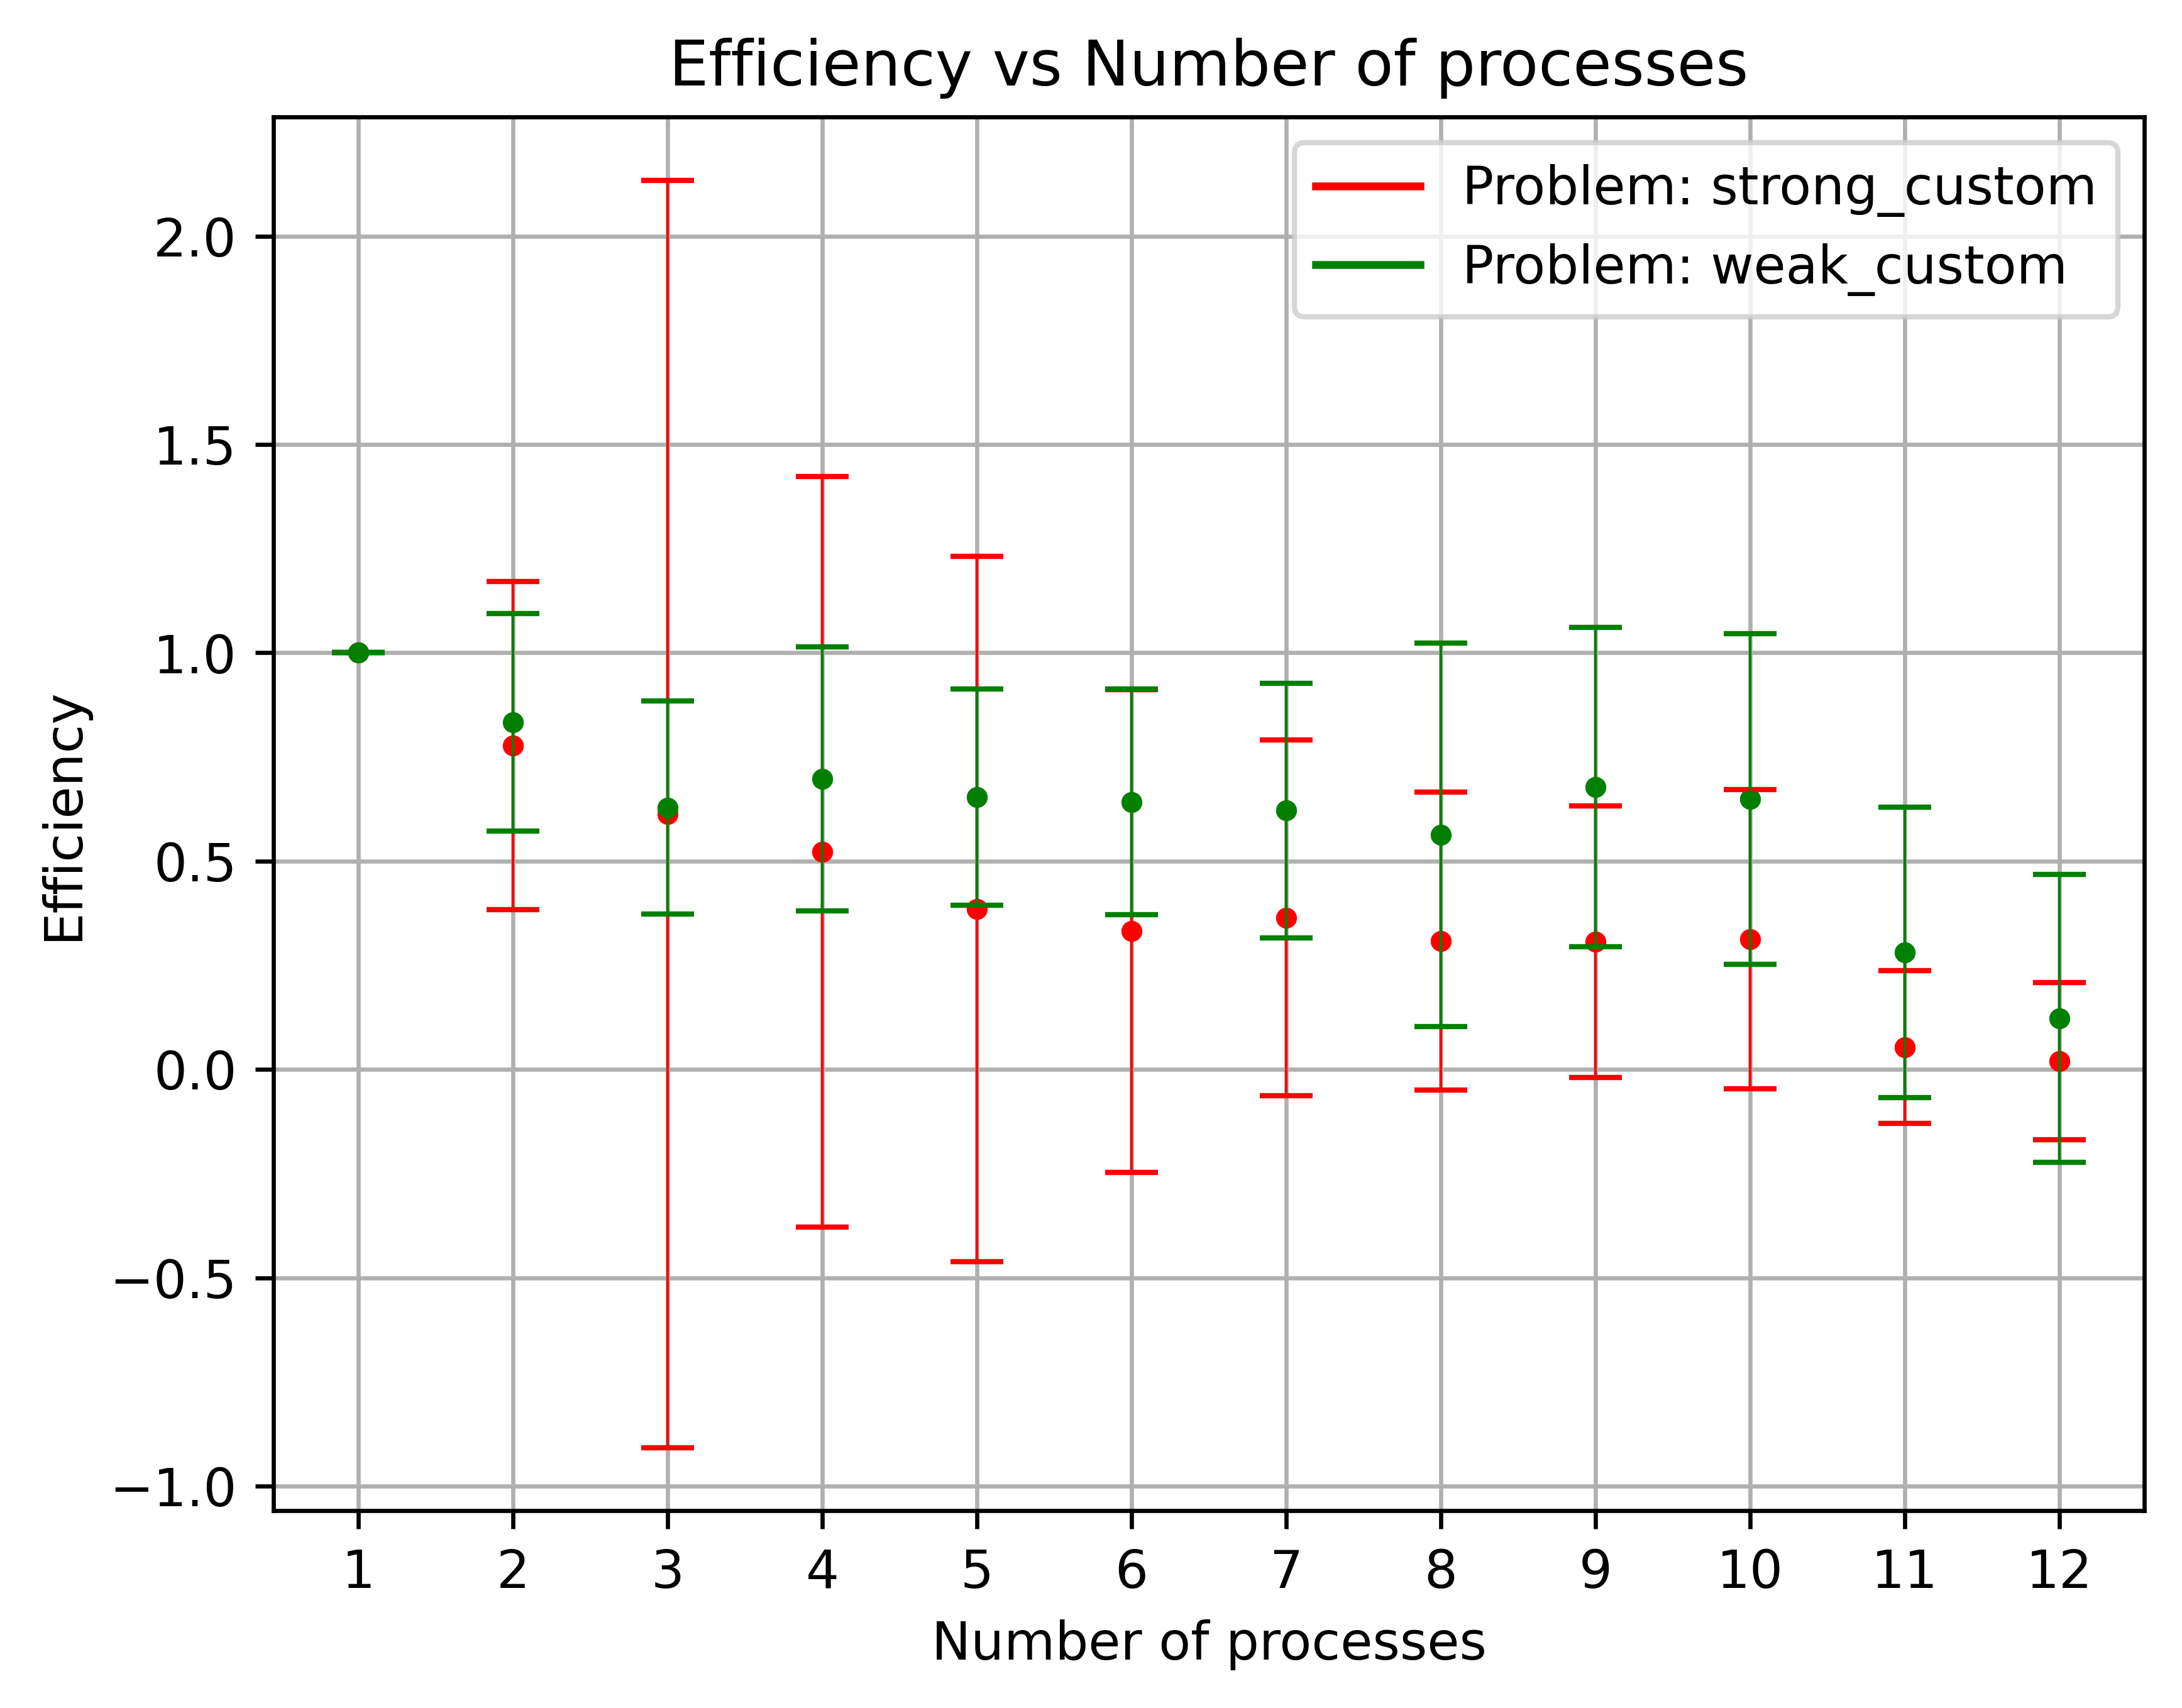

In [87]:
# calculate efficiency

def calc_eff(datas, speedups):
    efficiency_data = []
    for data_i, data in enumerate(datas):
        efficiency_data.append(pd.DataFrame(columns=["proc", "efficiency"]))

        # calculate efficiency for every 12 lines until the end of data
        for i in range(0, len(data)):
            efficiency_data[-1].loc[len(efficiency_data[-1])] = [
                (i % 12) + 1,
                speedups[data_i]["speedup"][i] / ((i % 12) + 1)
            ]
        
            # print((i % 12) + 1, speedups[data_i]["speedup"][i] , speedups[data_i]["speedup"][i] / ((i % 12) + 1))

    return efficiency_data

efficiency_data = calc_eff(datas, speedups_data)
efficiency_avg_data = calc_eff(avg_datas, speedups_avg_data)

plot_avg_std(efficiency_data, efficiency_avg_data, "efficiency", "Number of processes", "Efficiency", "Efficiency vs Number of processes")

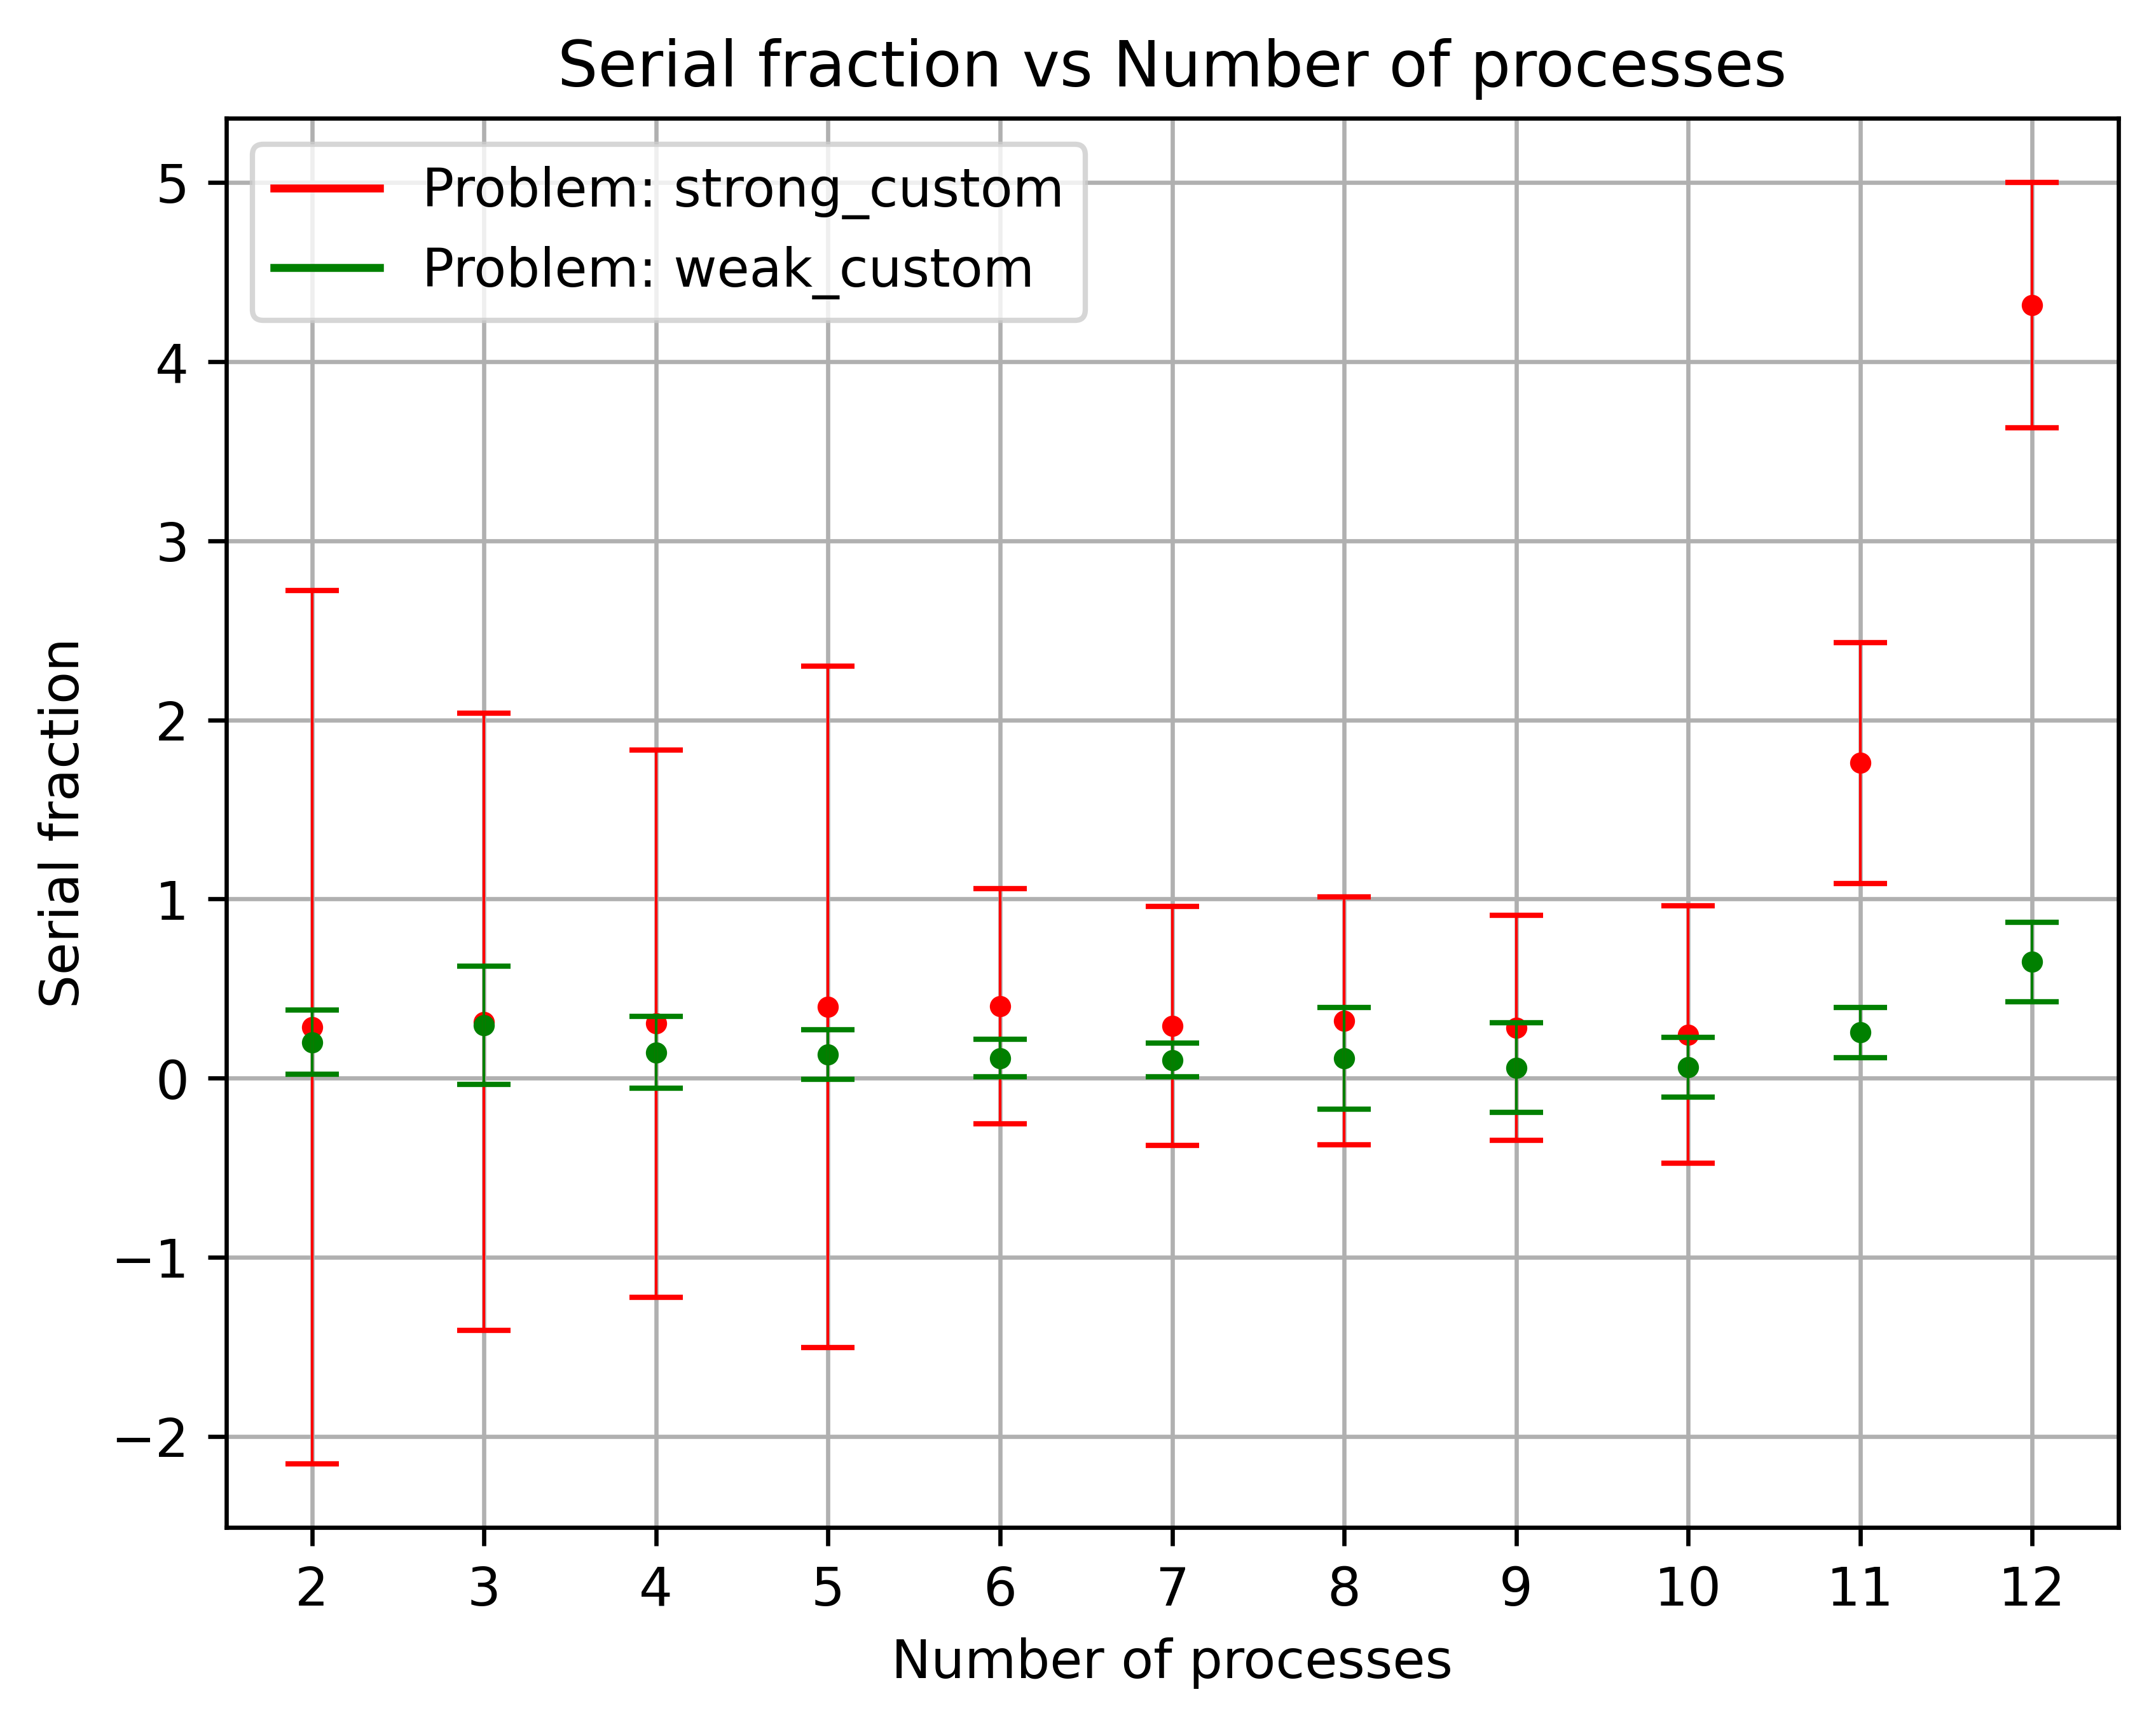

In [88]:
# calculate serial fraction

def calc_serial_fraction(datas, speedups):
    serial_fraction_data = []
    for data_i, data in enumerate(datas):        
        serial_fraction_data.append(pd.DataFrame(columns=["proc", "serial_fraction"]))

        # calculate efficiency for every 12 lines until the end of data
        for i in range(0, len(data)):
            if (i % 12) + 1 == 1: continue

            # serial fraction = (1 / speedup - 1 / processes) / (1 - 1 / processes)
            serial_fraction_data[-1].loc[len(serial_fraction_data[-1])] = [
                (i % 12) + 1,
                (1 / speedups[data_i]["speedup"][i] - 1 / ((i % 12) + 1)) / (1 - 1 / ((i % 12) + 1))
            ]
        
    return serial_fraction_data

serial_fraction_data = calc_serial_fraction(datas, speedups_data)
serial_fraction_avg_data = calc_serial_fraction(avg_datas, speedups_avg_data)

plot_avg_std(serial_fraction_data, serial_fraction_avg_data, "serial_fraction", "Number of processes", "Serial fraction", "Serial fraction vs Number of processes")